# Semantic segmentation with Vision Transformers, Hugging Face and TensorFlow

**Adapted from:** https://keras.io/examples/vision/segformer/<br>
**Description:** Fine-tuning a SegFormer model variant for semantic segmentation of geosptial data.

This tutorial demonstrates how to fine-tune a semantic segmentation architecture leveraging vision transformers on geospatial data to perform
a land cover semantic segmentation task. Specifically, we will leverage a SegFormer model variant.

SegFormer is based on what is known as a "Mix Transformer" hierarchical architecture for the encoder, and a lightweight MLP and upsampler for its decoder. This design has led to state-of-the-art performance and efficiency for semantic segmentation (in terms of [performance vs. model efficiency on the ADE20K benchmark dataset as of 2021](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k)). Newer architectures have since out-performed SegFormer on this benchmark dataset, however SegFormer's ease of use with Hugging Face Transformers makes it a good candidate to implement in this tutorial.

More details on the SegFormer architecture can be found in its initial publication:
[SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203).

![segformer-arch](https://i.imgur.com/BsrVwYe.png)

We will obtain a pre-trained SegFormer model from
[Hugging Face Transformers](https://github.com/huggingface/transformers)
and fine-tune it using publicly available geospatial data and labels from [Radiant Earth MLHub](https://mlhub.earth/).

**Note:** this tutorial adapts some code from the following:

* [Official tutorial on segmentation from the TensorFlow team](https://www.tensorflow.org/tutorials/images/segmentation)
* [Hugging Face Task guide on segmentation](https://huggingface.co/docs/transformers/main/en/tasks/semantic_segmentation)

In [ ]:
# install required libraries
!!pip install transformers==4.31.0
!pip install -q rasterio==1.3.8
!pip install -q geopandas==0.13.2
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/
!pip install tensorflow_io==0.32.0

In [2]:
import os, glob, tarfile, json
from pathlib import Path
from PIL import Image
import numpy as np
from radiant_mlhub import Dataset, Collection
import pandas as pd
from google.colab import drive
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import backend
import rasterio
from skimage.transform import resize
from transformers import TFSegformerForSemanticSegmentation

Mount google drive to access our generated inputs and outputs.

In [ ]:
# set your folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    processed_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-processed-outputs/'
    user_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-user_outputs_dir'
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
    print('Running on Colab')
else:
    processed_outputs_dir = os.path.abspath("./data/tf-eo-devseed-2-processed-outputs")
    user_outputs_dir = os.path.abspath('./tf-eo-devseed-2-user_outputs_dir')
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
        os.makedirs(processed_outputs_dir)
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(processed_outputs_dir)}')


In [ ]:
# Flag for whether to use pre-processed outputs or generate your own
use_preprocessed_outputs = True

In [ ]:
# Move to your user directory in order to write data
%cd $user_outputs_dir

# NOTE! If you want to use pre-processed outputs, uncomment the line below then skip the cells with topline comment "# Skip if using preprocessed outputs"
# %cd $processed_outputs_dir


## Load the geosaptial data for fine-tuning

We'll use the [LandCoverNet South America](https://mlhub.earth/data/ref_landcovernet_sa_v1) dataset for
this example, which includes Sentinel-1, Sentinel-2 and Landsat 8 rasters and land cover labels. This is a tremendous amount of data so we will create and use, for demonstration purposes, a subset of true color (red, green, blue) Landsat 8 rasters. Outside of this demonstration, we encourage experimenting with the other raster datasets.

In [ ]:
# configure Radiant Earth MLHub access, no need to do this if using pre-processed outputs
!mlhub configure

In [ ]:
# Check the available input data
ds = Dataset.fetch('ref_landcovernet_sa_v1')
for c in ds.collections:
    print(c.id)


ref_landcovernet_sa_v1_source_sentinel_2
ref_landcovernet_sa_v1_source_sentinel_1
ref_landcovernet_sa_v1_source_landsat_8
ref_landcovernet_sa_v1_labels


The next code block walks through the actual download of the input data from Radiant Earth using their Python API.

In [ ]:
# Skip if using preprocessed outputs
# Get Radiant Earth dataset
collections = [
    'ref_landcovernet_sa_v1_source_landsat_8',
    'ref_landcovernet_sa_v1_labels'
]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)

def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()

def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])

        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

if use_preprocessed_outputs==True:
    print("Using pre-processed outputs")
else:
    print("Using pre-processed outputs")
    for c in collections:
        download(c)
    #df = load_df('ref_landcovernet_sa_v1_labels')

### Pre-process the data for SegFormer

For preparing the datasets for training and evaluation, we:

* Partition the data into training, validation and testing sets.
* Generate true color (red, green, blue) images from the Landsat 8 input data.
* Resize the image tiles from 256x256 to 512x512 for use with the SegFormer model variant.
* Normalize the images with the mean and standard deviation used during pre-training SegFormer.
* Obtain the image labels with integer class values.
* Save the preprocess results to a local directory

In [6]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 4
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

In [8]:
if use_preprocessed_outputs==True:
    print("Using pre-processed outputs")
else:
    # Gather all samples from the Landsat 8 dataset. Each subdirectory points to a single sample.
    p = Path('ref_landcovernet_sa_v1_source_landsat_8/')
    subdirs = [f for f in p.iterdir() if f.is_dir()]
    print(len(subdirs)) # Number of samples. Should be 34229.

In [ ]:
# Function for running some of the preprocessing steps
def compile_dataset(impath, dataset_split):
  # Create partition directories
  dirs = [f"ref_landcovernet_sa_v1_rgb_images_png_512_{dataset_split}",  f"ref_landcovernet_sa_v1_label_images_png_512_{dataset_split}"]
  for d in dirs:
    if not os.path.exists(d):
      os.makedirs(d)
  # Generate true color (red, green, blue) images from the Landsat 8 input data.
  r = rasterio.open(f"{impath}/B04.tif").read().transpose(1,2,0)
  g = rasterio.open(f"{impath}/B03.tif").read().transpose(1,2,0)
  b = rasterio.open(f"{impath}/B02.tif").read().transpose(1,2,0)
  rgb = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)
  # Resize the image tiles from 256x256 to 512x512 for use with the SegFormer model variant.
  resized_rgb_image = resize(rgb, (image_size, image_size), order=0, preserve_range=True, anti_aliasing=False) #.astype('uint8')
  rgb_im = Image.fromarray(resized_rgb_image)
  im_id = impath.split('/')[1]
  rgb_im.save(f"ref_landcovernet_sa_v1_rgb_images_png_512_{dataset_split}/{im_id}.png", "PNG")
  #tiff.imsave(f"ref_landcovernet_sa_v1_rgb_images_fl_t_{dataset_split}/{im_id}.tif", rgb) #resized_rgb_image)
  maskpath = impath.replace("source_landsat_8", "labels")
  maskpath = maskpath[:-9]
  mask_file = f"{maskpath}/labels.tif"
  mask_image = rasterio.open(f"{mask_file}").read().transpose(1,2,0)
  # Obtain the image labels with integer class values.
  mask_image = mask_image[:, :, 0]
  resized_mask_image = resize(mask_image, (image_size, image_size), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
  mask_image = Image.fromarray(resized_mask_image)
  mask_image.save(f"ref_landcovernet_sa_v1_label_images_png_512_{dataset_split}/{im_id}.png", "PNG")

### Partition the data
Because we have 34229 data points to work with, let's just practice on a subset.
*   1000 samples for training to start
*   200 for validation
*   1000 for testing

In [11]:
def partition(part_string, part_start, part_end):
  i = 0
  for s in subdirs[part_start:part_end]:
    compile_dataset(str(s), part_string)
    i = i+1
  return

In [ ]:
if use_preprocessed_outputs==True:
    print("Using pre-processed outputs")
else:
    # Partition the dataset
    partition("train", 0, 1000)
    partition("val", 1001, 1201)
    partition("test", 1202, 2202)

### Build the dataloader for each partition

We now use the above utilities to prepare dataset objects including
`prefetch()` for performance.

Now that the data has been partitioned, we will compile the splits into `tf.data.Dataset`s using `prefetch()` for efficiency (read more on this method [here](https://www.tensorflow.org/guide/data_performance#prefetching)).

In [ ]:
def normalize(input_image):
  # Normalize to mean values used in SegFormer pretraining
  input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
  return input_image


def load(image_file, mask_file):
  # Load images and labels as tensors
  image = tf.io.read_file(image_file)
  #image = tfio.experimental.image.decode_tiff(image)
  image = tf.io.decode_png(image)

  mask = tf.io.read_file(mask_file)
  mask = tf.io.decode_png(mask)

  input_image = tf.cast(image, tf.float32)
  mask_image = tf.cast(mask, tf.float32)


  input_image = tf.image.resize(input_image, (image_size, image_size))
  input_mask = tf.image.resize(
        mask_image,
        (image_size, image_size),
        method="nearest",
        antialias=False,
  )

  input_image = normalize(input_image)
  # Transpose image to channels first format
  input_image = tf.transpose(input_image, (2, 0, 1))
  reshaped_input_mask = tf.reshape(input_mask, (512, 512, 1))
  return {"pixel_values": input_image, "labels": tf.squeeze(reshaped_input_mask)}


train_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_png_512_train//*.*')
train_labels = glob.glob('ref_landcovernet_sa_v1_label_images_png_512_train//*.*')
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_png_512_val//*.*')
val_labels = glob.glob('ref_landcovernet_sa_v1_label_images_png_512_val//*.*')
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

test_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_png_512_test//*.*')
test_labels = glob.glob('ref_landcovernet_sa_v1_label_images_png_512_test//*.*')
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds = (
    train_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )


val_ds = (
    val_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )


test_ds = (
    test_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

It's useful to inspect the shapes of the input images and segmentation masks.

In [ ]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


## Visualize the dataset

It's also nice to get a visual depiction of the processed samples

In [ ]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(5, 5))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(10):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    #print(sample_image.shape, sample_mask.shape)
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    #print(sample_image.shape, sample_mask.shape, tf.unique(tf.reshape(sample_mask,[-1])))
    display([sample_image, sample_mask])

## Load a pretrained SegFormer checkpoint

Now, we will select a pretrained SegFormer model variant and load it from [Hugging Face Transformers](https://huggingface.co/docs/transformers/index). There are several
SegFormer model variants, i.e. **MiT-B0** and **MiT-B5**. The checkpoints for all can be accessed
[here](https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads&search=segformer).
For this tutorial, we are loading the smallest variant, Mix-B0, which suffices to show its use and offers a nice balance between inference speed and accuracy performance.

In [ ]:
model_checkpoint = "nvidia/mit-b0"

# Classes below derived from https://radiantearth.blob.core.windows.net/mlhub/landcovernet_sa/Documentation.pdf

id2label = {0: "Background", 1: "water", 2: "artificial_bare_ground", 3: "natural_bare_ground", 4: "permanent_snow_ice", 5: "woody_vegetation", 6: "cultivated_vegetation", 7: "semi_natural_vegetation"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

You might see a warning that states some weights are not initialized and new ones are being created. That's totally normal as we are finetuning this model with a custom dataset with a different class schema than the dataset used for pre-training.

[`TFSegformerForSemanticSegmentation`](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.TFSegformerForSemanticSegmentation)
attaches a unique decoder head for our custom dataset using associated parameters.

## Compile the model

Now we will compile the model, whilst selecting our optimizer and learning rate.

In [ ]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

Of note, you'll see that no loss function is defined. Reason being, the forward pass of the SegFormer network [implements](https://github.com/huggingface/transformers/blob/820c46a707ddd033975bc3b0549eea200e64c7da/src/transformers/models/segformer/modeling_tf_segformer.py#L873) loss computation on the labels and images provided as input. From that, the model returns a structured `dataclass` object that is in turn used to pilot the model during training.

Now that the model is compiled, we will add a few callbacks to monitor information during training, and then we will execute model training with the `fit()` method.

## Prediction callback to monitor training progress

This callback enables us to visualize interim predictive progress of the model during training. It is inspired from
[this tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

In [ ]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


## Train model

In [ ]:
# Increase the number of epochs if the results are not of expected quality.
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(val_ds)],
    epochs=EPOCHS,
)

## Inference

Let's use the finetuned model to predict generate some predictions from the test set.

1/1 [==============================] - 0s 217ms/step


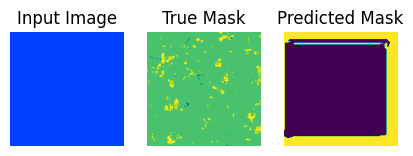

1/1 [==============================] - 0s 174ms/step


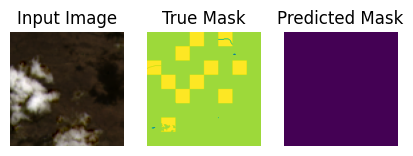

1/1 [==============================] - 0s 305ms/step


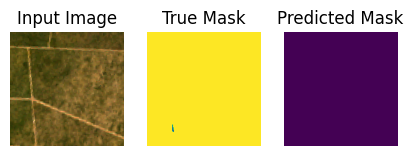

1/1 [==============================] - 0s 116ms/step


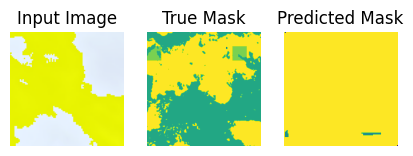

1/1 [==============================] - 0s 122ms/step


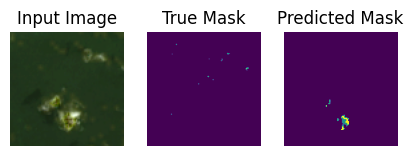

1/1 [==============================] - 0s 105ms/step


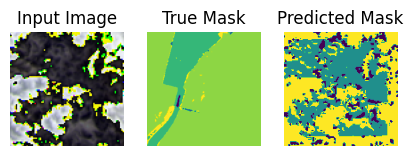

1/1 [==============================] - 0s 108ms/step


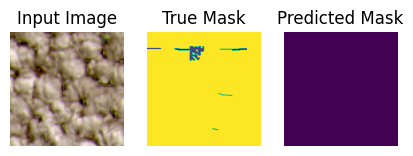

1/1 [==============================] - 0s 127ms/step


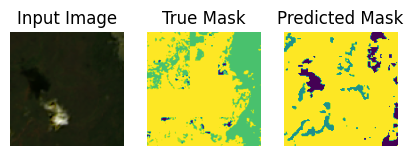

1/1 [==============================] - 0s 123ms/step


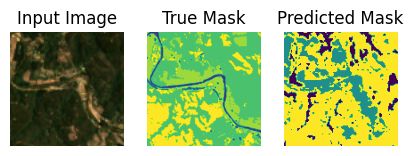

1/1 [==============================] - 0s 113ms/step


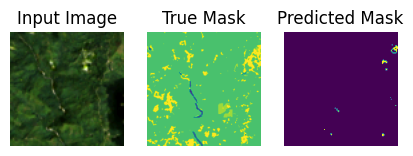

In [ ]:
show_predictions(test_ds, 10)

## Conclusion

This was a brief introduction to the use of vision transformers by way of the SegFormer architecture for use in a custom semantic segmentation task.

In further experimentation, you are encouraged to:

* Add data augmentation into the pre-processing to explore how that affects model accuracy and robustness.
* Load and finetune from a larger SegFormer model checkpoint.
* Share the fine-tuned model to the Hugging Face Hub for others to try out. This can be done through `model.push_to_hub("your-username/your-awesome-model")`.
Then, you can load the model by
`TFSegformerForSemanticSegmentation.from_pretrained("your-username/your-awesome-model"`).
An end-to-end example of this is [here](https://github.com/huggingface/notebooks/blob/main/examples/semantic_segmentation-tf.ipynb).
* There is also a callback that allows for you to push the model checkpoints to the Hugging Face Hub whilst the model is being
fine-tuned. It is the `PushToHubCallback` Keras callback.
An example is [here](https://gist.github.com/sayakpaul/f474ffb01f0cdcc8ba239357965c3bca) and [here](https://huggingface.co/sayakpaul/mit-b0-finetuned-pets) is an example usage of this callback.